In [1]:
import numpy as np

from astropy.table import Table
from astropy.io import ascii
import astropy.units as u

import matplotlib.pyplot as plt

from snewpy.models import Fornax_2019
from snewpy.neutrino import Flavor

In [3]:
ifile = '../../models/Fornax_2019/data/lum_spec_10M'
model = Fornax_2019(ifile)

## Plot the initial spectra
Currently, `get_initialspectra()` returns the number luminosity in units of s$^{-1}$, as opposed to a number flux in units of ergs$^{-1}$s$^{-1}$

In [4]:
t = 0.1 * u.s
E = np.linspace(0,100,201) * u.MeV
spectrum = model.get_initialspectra(t, E)

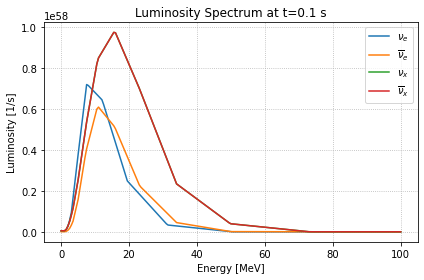

In [6]:
fig, ax = plt.subplots()
for flavor in Flavor:
    ax.plot(E, spectrum[flavor.name], label = flavor.to_tex())
ax.grid(ls = ':')
ax.set(title = 'Luminosity Spectrum at t={}'.format(t),
       xlabel = 'Energy [MeV]',
       ylabel = 'Luminosity [1/s]')
ax.legend()
fig.tight_layout()
# fig.savefig('Fornax_2019_luminosity.png')

In [7]:
def plot_spectrum(model):
    # Plot the energy vs time spectrum
    
    t = model.get_time()
    fig, axes = plt.subplots(1, 3, figsize = (17, 5))
    energy = model.get_energy_bins()
    luminosity = model.get_luminosity_bins()
    mass = model.get_mass()
    
    for flavor, ax in zip(Flavor, axes.flatten()):
    
        ene = energy[flavor.name]
        lum = luminosity[flavor.name] / 1e50 # scaling factor

        emin = np.log10(np.min(ene).value)
        emax = np.log10(np.max(ene).value)

        im = ax.imshow(lum.value, extent=[t[0].value, t[-1].value, emin, emax],
                       origin='lower', vmin=0, vmax=150)
        cb = fig.colorbar(im, ax=ax)
        cb.set_label(r'{:s} $\Delta L / \Delta E_i$ [$10^{{50}}$ erg s$^{{-1}}$ MeV $^{{-1}}$]'.format(flavor.to_tex()))

        ratio = 1.0 * (t[-1].value - t[0].value) / (emax - emin)
        ax.set(aspect=ratio,
               xlabel='time [s]',
               ylabel='log$_{10}$(energy / MeV)',
               title='{:g}$M_\odot$'.format(mass.value))

    fig.tight_layout()
    return fig

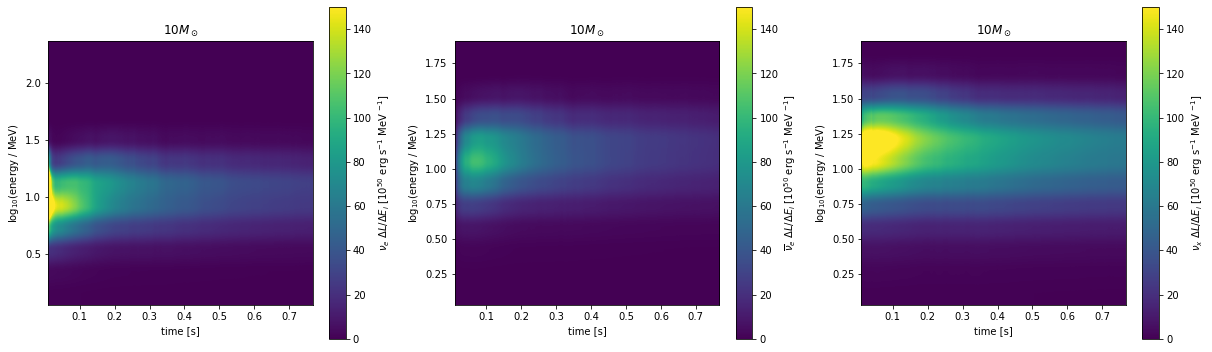

In [8]:
fig = plot_spectrum(model)